<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Esercizio Martalò


In [ ]:
!pip install pandas
!pip install numpy

import pandas as pd
import numpy as np

# Import the dataset and create a dataframe
traffic_df = pd.read_csv("Train_Test_Network.csv")
print(traffic_df.columns)

# We need to isolate the fields of interest
clean_df = traffic_df[["proto", "label", "type"]]
print(clean_df)

feature = "type"
analysis_df = clean_df[feature]
print("analysis_df: ", analysis_df)
# counts the unique values for the selected feature and order them
val_count = analysis_df.value_counts().sort_index()
print(val_count)


Index(['ts', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'proto', 'service',
       'duration', 'src_bytes', 'dst_bytes', 'conn_state', 'missed_bytes',
       'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_query',
       'dns_qclass', 'dns_qtype', 'dns_rcode', 'dns_AA', 'dns_RD', 'dns_RA',
       'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed',
       'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth',
       'http_method', 'http_uri', 'http_version', 'http_request_body_len',
       'http_response_body_len', 'http_status_code', 'http_user_agent',
       'http_orig_mime_types', 'http_resp_mime_types', 'weird_name',
       'weird_addl', 'weird_notice', 'label', 'type'],
      dtype='object')
       proto  label        type
0        tcp      0      normal
1        udp      0      normal
2        tcp      0      normal
3        tcp      0      normal
4        udp      0      normal
...      ...    ...         ...
461038   tcp      1         xss
4610

In [ ]:
# Try to extract some statistics
type_proto_counts = clean_df.groupby('type')['proto'].value_counts().unstack(fill_value=0)
print(type_proto_counts)

proto       icmp     tcp     udp
type                            
backdoor       0   19990      10
ddos           0   14730    5270
dos            0   18520    1480
injection      0   19270     730
mitm          58     416     569
normal      5723  131532  162745
password       0   19820     180
ransomware    99   19774     127
scanning       0   19424     576
xss            0   18600    1400


In [ ]:
# Create categories
category_mapping = {
    'backdoor': 'Malevolent',
    'ddos': 'Malevolent',
    'dos': 'Malevolent',
    'injection': 'Malevolent',
    'mitm': 'Malevolent',
    'normal': 'Benevolent',
    'password': 'Malevolent',
    'ransomware': 'Malevolent',
    'scanning': 'Malevolent',
    'xss': 'Malevolent',
}

# Use .loc to modify the original DataFrame
clean_df.loc[:, 'type'] = clean_df['type'].replace(category_mapping)

In [ ]:
subset_size = 1000
# shuffle the dataframe and make the index start from 0 again
clean_df = clean_df.sample(frac=1).reset_index(drop=True)
print(clean_df)


       proto  label        type
6859     tcp      1  Malevolent
185524   udp      0  Benevolent
74793    tcp      1  Malevolent
226101   udp      0  Benevolent
452050   udp      0  Benevolent
...      ...    ...         ...
100815   udp      0  Benevolent
406994   tcp      0  Benevolent
129923   udp      1  Malevolent
50317    tcp      1  Malevolent
327648   tcp      0  Benevolent

[461043 rows x 3 columns]
       proto  label        type
0        tcp      1  Malevolent
1        tcp      0  Benevolent
2        udp      0  Benevolent
3        tcp      0  Benevolent
4        udp      0  Benevolent
...      ...    ...         ...
461038   tcp      0  Benevolent
461039   udp      0  Benevolent
461040   tcp      1  Malevolent
461041   tcp      0  Benevolent
461042   tcp      0  Benevolent

[461043 rows x 3 columns]


In [ ]:
# divide dataframe into subsets of 1000 samples
subsets = [clean_df.iloc[i:i+subset_size] for i in range(0, len(clean_df), subset_size)]
print(subsets[0])

subset_numbers = []
percent_tcp_normal = []
percent_tcp_malevolent = []

# Calculate the percentage of TCP in "proto" for each class in each subnet
for i, subset in enumerate(subsets, start=1):
    # count the number of benevolent packets for the current subset
    total_obs_ben = subset[subset['type'] == 'Benevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_ben = total_obs_ben.get('Benevolent', 0)
    #print(total_obs_ben)
    #print(tcp_counts)

    total_obs_mal = subset[subset['type'] == 'Malevolent']['type'].value_counts(normalize=False)
    #print("\nSubset ", i)
    #print(total_obs_ben)
    total_obs_mal = total_obs_mal.get('Malevolent', 0)
    #print(total_obs_ben)

    # count the number of TCP benevolent packets for current subset
    tcp_counts = subset[subset["proto"] == 'tcp']['type'].value_counts(normalize=False)

    # Append the results to the lists
    subset_numbers.append(i)
    if total_obs_ben != 0:
        percent_tcp_normal.append(tcp_counts.get('Benevolent', 0) * 100 / total_obs_ben)
    else:
        percent_tcp_normal.append(0)
    print(f"Percentage: {percent_tcp_normal}")

    if total_obs_mal != 0:
        percent_tcp_malevolent.append(tcp_counts.get('Malevolent', 0) * 100 / total_obs_mal)
    else:
        percent_tcp_malevolent.append(0)

    proto  label        type
0     tcp      1  Malevolent
1     tcp      0  Benevolent
2     udp      0  Benevolent
3     tcp      0  Benevolent
4     udp      0  Benevolent
..    ...    ...         ...
995   tcp      1  Malevolent
996   udp      0  Benevolent
997   udp      0  Benevolent
998   tcp      0  Benevolent
999   udp      0  Benevolent

[1000 rows x 3 columns]
Percentage: [46.33757961783439]
Percentage: [46.33757961783439, 43.684992570579496]
Percentage: [46.33757961783439, 43.684992570579496, 43.03215926493109]
Percentage: [46.33757961783439, 43.684992570579496, 43.03215926493109, 43.11377245508982]
Percentage: [46.33757961783439, 43.684992570579496, 43.03215926493109, 43.11377245508982, 45.303030303030305]
Percentage: [46.33757961783439, 43.684992570579496, 43.03215926493109, 43.11377245508982, 45.303030303030305, 43.78787878787879]
Percentage: [46.33757961783439, 43.684992570579496, 43.03215926493109, 43.11377245508982, 45.303030303030305, 43.78787878787879, 44.44444444444

## Progetto

In [2]:
import pandas as pd

url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)

print(traffic_df.shape)


(90000, 34)


In [6]:
print(traffic_df)

       Domain DNSRecordType  MXDnsResponse  TXTDnsResponse  HasSPFInfo  \
0        4455             A          False           False       False   
1        4456             A          False           False       False   
2        4457             A          False           False       False   
3        4458             A          False           False       False   
4        4459             A          False           False       False   
...       ...           ...            ...             ...         ...   
89995   75661             A          False           False       False   
89996   54843             A          False           False       False   
89997   71235             A          False           False       False   
89998   82994             A           True            True        True   
89999   64601             A          False           False       False   

       HasDkimInfo  HasDmarcInfo     Ip  DomainInAlexaDB  CommonPorts  ...  \
0            False         False 

In [12]:
print(traffic_df['Entropy'])

0        4
1        4
2        4
3        4
4        4
        ..
89995    3
89996    3
89997    3
89998    3
89999    3
Name: Entropy, Length: 90000, dtype: int64


<Axes: >

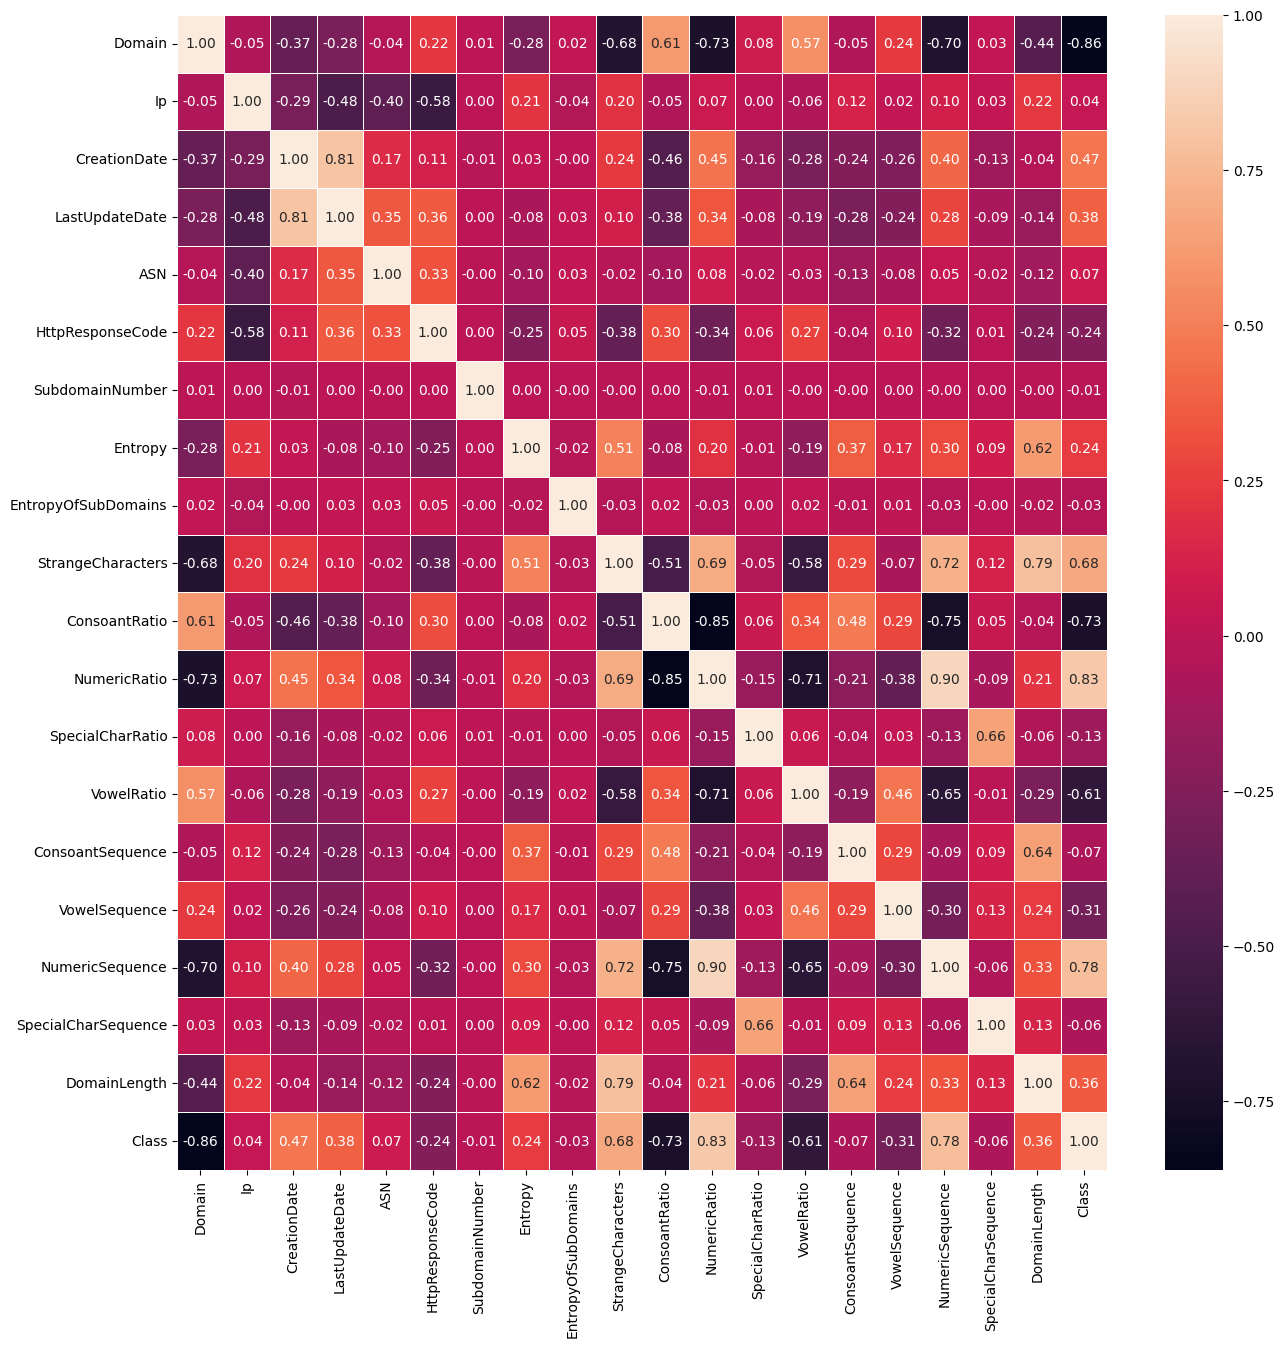

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
#corr[0][] = traffic_df['Entropy'].corr(traffic_df['Entropy'])

new_numeric_dataset = traffic_df.select_dtypes(include='number')
# print(new_numeric_dataset)
corr_matrix = new_numeric_dataset.corr()
#print(corr_matrix)
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')
